# Import packages

In [1]:
# ==================== Core Python Utilities ====================
import os
import sys
import json
import random
import shutil
import zipfile
import warnings
from datetime import datetime
from collections import Counter

# ==================== Data Handling ====================
import numpy as np
import pandas as pd
from tqdm import tqdm

# ==================== Audio Processing ====================
import librosa
import librosa.display
import IPython.display as ipd  # For audio playback in notebooks

# ==================== Visualization ====================
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import FileLink, display  # Jupyter Display Utilities

# ==================== Machine Learning & Preprocessing ====================
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.utils.class_weight import compute_class_weight

# ==================== Deep Learning (TensorFlow / Keras) ====================
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import (
    Input, Dense, Dropout, BatchNormalization, Add, LeakyReLU, Lambda, Attention,
    Conv1D, MaxPooling1D, GlobalAveragePooling1D,
    LSTM, Bidirectional
)

# ==================== HuggingFace Transformers (HuBERT) ====================
from transformers import HubertModel, Wav2Vec2FeatureExtractor

# ==================== KaggleHub (Optional) ====================
import kagglehub as kagglehub  # For downloading models/resources if required

# ==================== Torch ====================
import torch

# ==================== Suppress Warnings ====================
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)



# Data preparation

In [2]:
# downloading the four datasets
SAVEE = kagglehub.dataset_download("ejlok1/surrey-audiovisual-expressed-emotion-savee")
RAV = kagglehub.dataset_download("uwrfkaggler/ravdess-emotional-speech-audio")
CREMAD = kagglehub.dataset_download("ejlok1/cremad")
TESS = kagglehub.dataset_download("ejlok1/toronto-emotional-speech-set-tess")


In [3]:
# transform the four datasets to four dfs.
# SAVEE
SAVEE_PATH = SAVEE + '/ALL/'
dir_list = os.listdir(SAVEE_PATH)
emotion = []
path = []
for i in dir_list:
    if i[-8:-6] == '_a':
        emotion.append('angry')
    elif i[-8:-6] == '_d':
        emotion.append('disgust')
    elif i[-8:-6] == '_f':
        emotion.append('fear')
    elif i[-8:-6] == '_h':
        emotion.append('happy')
    elif i[-8:-6] == '_n':
        emotion.append('neutral')
    elif i[-8:-6] == 'sa':
        emotion.append('sad')
    elif i[-8:-6] == 'su':
        emotion.append('surprise')
    else:
        emotion.append('error')
    path.append(SAVEE_PATH + i)
SAVEE_df = pd.DataFrame({"label": emotion, "path": path, "source": "SAVEE"})

# RAVDESS
emotion_dict = {
    1: 'neutral', 2: 'neutral', 3: 'happy', 4: 'sad',
    5: 'angry', 6: 'fear', 7: 'disgust', 8: 'surprise'
}
emotions = []
paths = []
for folder in os.listdir(RAV):
    folder_path = os.path.join(RAV, folder)
    if "Actor" not in folder:
        continue
    for file in os.listdir(folder_path):
        full_path = os.path.join(folder_path, file)
        emo_code = int(file[6:8])
        emotion = emotion_dict.get(emo_code, "unknown")
        paths.append(full_path)
        emotions.append(emotion)
RAV_df = pd.DataFrame({"label": emotions, "path": paths, "source": "RAVDESS"})

# CREMA-D
emotions = []
paths = []
emotion_dict = {
    "ANG": "angry", "DIS": "disgust", "FEA": "fear",
    "HAP": "happy", "NEU": "neutral", "SAD": "sad"
}
for folder in os.listdir(CREMAD):
    folder_path = os.path.join(CREMAD, folder)
    for file in os.listdir(folder_path):
        if not file.endswith(".wav"):
            continue
        emo_code = file[9:12]
        emotion = emotion_dict.get(emo_code, "unknown")
        file_path = os.path.join(folder_path, file)
        emotions.append(emotion)
        paths.append(file_path)
CREMA_df = pd.DataFrame({"label": emotions, "path": paths, "source": "CREMA-D"})

# TESS
TESS_path = os.path.join(TESS, "TESS Toronto emotional speech set data")
dir_list = os.listdir(TESS_path)
path = []
emotion = []
for i in dir_list:
    folder_path = os.path.join(TESS_path, i)
    fname = os.listdir(folder_path)
    for f in fname:
        if 'angry' in i.lower():
            emotion.append('angry')
        elif 'disgust' in i.lower():
            emotion.append('disgust')
        elif 'fear' in i.lower():
            emotion.append('fear')
        elif 'happy' in i.lower():
            emotion.append('happy')
        elif 'neutral' in i.lower():
            emotion.append('neutral')
        elif 'surprise' in i.lower():
            emotion.append('surprise')
        elif 'sad' in i.lower():
            emotion.append('sad')
        else:
            emotion.append('unknown')
        path.append(os.path.join(folder_path, f))
TESS_df = pd.DataFrame({"label": emotion, "path": path, "source": "TESS"})

# combine all the dfs.
all_df = pd.concat([SAVEE_df, RAV_df, CREMA_df, TESS_df], ignore_index=True)

In [4]:
# check the schema and sample of the combined df.
all_df

,label,path,source
0,happy,/kaggle/input/surrey-audiovisual-expressed-emo...,SAVEE
1,fear,/kaggle/input/surrey-audiovisual-expressed-emo...,SAVEE
2,happy,/kaggle/input/surrey-audiovisual-expressed-emo...,SAVEE
3,disgust,/kaggle/input/surrey-audiovisual-expressed-emo...,SAVEE
4,angry,/kaggle/input/surrey-audiovisual-expressed-emo...,SAVEE
...,...,...,...
12157,surprise,/kaggle/input/toronto-emotional-speech-set-tes...,TESS
12158,surprise,/kaggle/input/toronto-emotional-speech-set-tes...,TESS
12159,surprise,/kaggle/input/toronto-emotional-speech-set-tes...,TESS
12160,surprise,/kaggle/input/toronto-emotional-speech-set-tes...,TESS


In [5]:
# check label distribution
all_df['label'].value_counts()

,count
label,
happy,1923
fear,1923
disgust,1923
angry,1923
sad,1923
neutral,1895
surprise,652


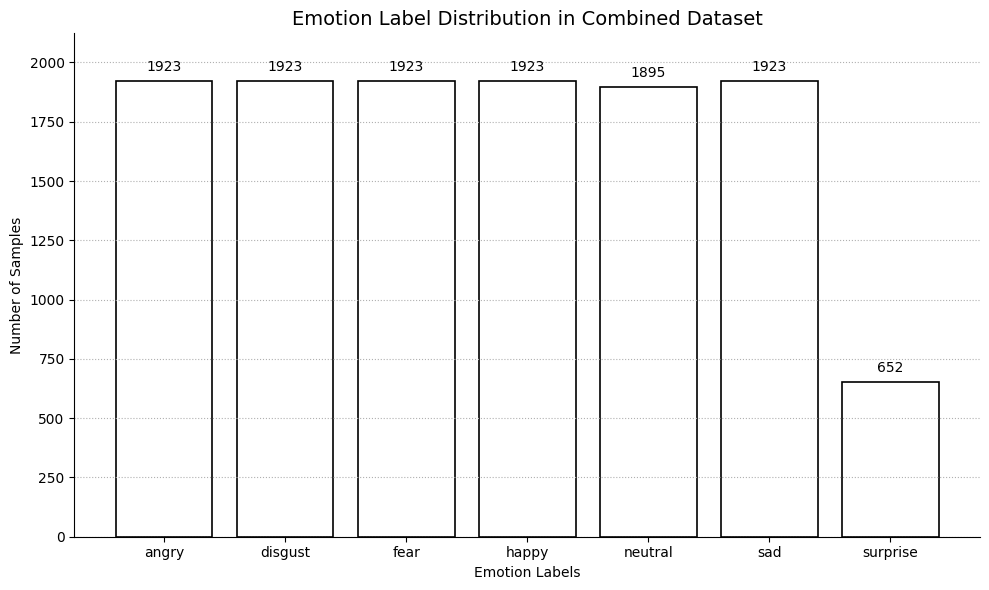

In [6]:
import pandas as pd
import matplotlib.pyplot as plt



label_counts = all_df['label'].value_counts().sort_index()

plt.figure(figsize=(10,6))
bars = plt.bar(label_counts.index, label_counts.values, color='white', edgecolor='black', linewidth=1.2)

# add data labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 30, str(height),
             ha='center', va='bottom', fontsize=10)

plt.title('Emotion Label Distribution in Combined Dataset', fontsize=14)
plt.xlabel('Emotion Labels')
plt.ylabel('Number of Samples')
plt.ylim(0, label_counts.values.max() + 200)

plt.grid(axis='y', linestyle=':', linewidth=0.8)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tight_layout()

plt.savefig('emotion_label_distribution.png', dpi=300)

plt.show()


In [7]:
# check each df rows
print("SAVEE_df rows:", len(SAVEE_df))
print("RAV_df rows:", len(RAV_df))
print("CREMA_df rows:", len(CREMA_df))
print("TESS_df rows:", len(TESS_df))
# RAV_df.count()

SAVEE_df rows: 480
RAV_df rows: 1440
CREMA_df rows: 7442
TESS_df rows: 2800


# HuBERT feature extraction

## P1. Best model: mean+std pooling HuBRET feature extraction (77.89%)

In [8]:
# === 0. Preliminaries ===
SR = 16000
DURATION = 4.0
OFFSET = 0.5
MAX_LEN = int(SR * DURATION)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LAYER_SELECT = -4    # Middle layer for better generalization

save_dir = "hubert_meanstd_no_aug"
os.makedirs(save_dir, exist_ok=True)

# === Load HuBERT ===
model = HubertModel.from_pretrained("facebook/hubert-base-ls960").to(DEVICE)
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("facebook/hubert-base-ls960")
model.eval()

# === Functions ===
def load_audio_segment(path):
    audio, _ = librosa.load(path, sr=SR, offset=OFFSET, duration=DURATION)
    return np.pad(audio, (0, max(0, MAX_LEN - len(audio))))[:MAX_LEN]

def extract_meanstd_feature(audio):
    inputs = feature_extractor(audio, sampling_rate=SR, return_tensors="pt")
    with torch.no_grad():
        hidden_states = model(inputs.input_values.to(DEVICE), output_hidden_states=True).hidden_states
        selected = hidden_states[LAYER_SELECT].squeeze(0).cpu().numpy()
    mean_pool = np.mean(selected, axis=0)
    std_pool = np.std(selected, axis=0)
    return np.concatenate([mean_pool, std_pool])   # Shape: [1536]

# === 1. Split Train / Val ===
train_df, val_df = train_test_split(all_df, test_size=0.2, random_state=42, stratify=all_df['label'])
print(f"Train: {len(train_df)}, Val: {len(val_df)}")

# === 2. One-Hot Encoding ===
ohe = OneHotEncoder(sparse_output=False)
ohe.fit(all_df[['label']])
label_names = ohe.categories_[0].tolist()

with open(os.path.join(save_dir, "label_names.json"), "w") as f:
    json.dump(label_names, f)

# === 3. Process Train Set (No Augmentation) ===
train_features, train_labels = [], []
for _, row in tqdm(train_df.iterrows(), total=len(train_df), desc="Extracting Train Features"):
    audio = load_audio_segment(row['path'])
    train_features.append(extract_meanstd_feature(audio))
    train_labels.append(row['label'])

X_train = np.stack(train_features)
y_train = ohe.transform(np.array(train_labels).reshape(-1,1))

# === 4. Process Val Set (No Augmentation) ===
val_features, val_labels = [], []
for _, row in tqdm(val_df.iterrows(), total=len(val_df), desc="Extracting Val Features"):
    audio = load_audio_segment(row['path'])
    val_features.append(extract_meanstd_feature(audio))
    val_labels.append(row['label'])

X_val = np.stack(val_features)
y_val = ohe.transform(np.array(val_labels).reshape(-1,1))

# === 5. Save Features ===
np.save(os.path.join(save_dir, "X_train.npy"), X_train)
np.save(os.path.join(save_dir, "y_train.npy"), y_train)
np.save(os.path.join(save_dir, "X_val.npy"), X_val)
np.save(os.path.join(save_dir, "y_val.npy"), y_val)

print(f"🎯 Features saved: Train {X_train.shape}, Val {X_val.shape}")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/378M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/213 [00:00<?, ?B/s]

Train: 9729, Val: 2433


Extracting Train Features:   0%|          | 0/9729 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

Extracting Train Features: 100%|██████████| 9729/9729 [05:22<00:00, 30.21it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
Extracting Val Features: 100%|██████████| 2433/2433 [01:17<00:00, 31.27it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(


🎯 Features saved: Train (9729, 1536), Val (2433, 1536)


In [9]:
# === 6. Build MLP + Self-Attention Model ===
inputs = Input(shape=(X_train.shape[1],))
x = Dense(512, kernel_regularizer=tf.keras.regularizers.l2(1e-4))(inputs)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(0.4)(x)
residual = Dense(512)(x)
x = Dense(384)(x)
x = LeakyReLU()(x)
x = Dense(512)(x)
x = BatchNormalization()(x)
x = Add()([x, residual])
x_expanded = Lambda(lambda t: tf.expand_dims(t, axis=1))(x)
attn_out = Attention()([x_expanded, x_expanded])
x = Lambda(lambda t: tf.squeeze(t, axis=1))(attn_out)
x = Dense(128, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(y_train.shape[1], activation='softmax')(x)

model = Model(inputs, outputs)
model.summary()
model.compile(optimizer=tf.keras.optimizers.AdamW(1e-4),
              loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.08),
              metrics=['accuracy'])

# === 7. Train Model ===
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
]
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=80,
                    batch_size=128,
                    callbacks=callbacks,
                    verbose=1)

model.save(os.path.join(save_dir, "final_model_meanstd.keras"))
print("✅ Training complete & model saved!")

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1536)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 512)       │    786,944 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 512)       │      2,048 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 512)       │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512)       │          0 │ leaky_re_lu[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 384)       │    196,992 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 384)       │          0 │ dense_2[0][0]     │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 512)       │    197,120 │ leaky_re_lu_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dense_3[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 512)       │    262,656 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 512)       │          0 │ batch_normalizat… │
│                     │                   │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 1, 512)    │          0 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 1, 512)    │          0 │ lambda[0][0],     │
│ (Attention)         │                   │            │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 512)       │          0 │ attention[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128)       │     65,664 │ lambda_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 64)        │      8,256 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 7)         │        455 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,522,183 (5.81 MB)

 Trainable params: 1,520,135 (5.80 MB)

 Non-trainable params: 2,048 (8.00 KB)

Epoch 1/80


/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


77/77 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - accuracy: 0.2214 - loss: 2.5320 - val_accuracy: 0.3239 - val_loss: 1.9562 - learning_rate: 1.0000e-04
Epoch 2/80
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3696 - loss: 1.8144 - val_accuracy: 0.4110 - val_loss: 1.8711 - learning_rate: 1.0000e-04
Epoch 3/80
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4557 - loss: 1.6187 - val_accuracy: 0.4365 - val_loss: 1.7595 - learning_rate: 1.0000e-04
Epoch 4/80
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5086 - loss: 1.5191 - val_accuracy: 0.5462 - val_loss: 1.6021 - learning_rate: 1.0000e-04
Epoch 5/80
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5496 - loss: 1.4320 - val_accuracy: 0.6519 - val_loss: 1.4766 - learning_rate: 1.0000e-04
Epoch 6/80
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5858 - loss: 1.3643 - val_accuracy: 0.6753 - val_loss: 1.3036 - learning_rate: 1.0000e-04
Epoch 7/80
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6076 - loss: 1.3304 -

## Explainable Analyais


In [10]:
# Find the attention layer name
attention_layer_name = None
for layer in model.layers:
    if isinstance(layer, tf.keras.layers.Attention):
        attention_layer_name = layer.name
        break

if attention_layer_name is None:
    raise ValueError("Didn't find attention layer，please check the model ")


In [11]:
# Create a new model，generate the output of attention layer.
attention_extractor = tf.keras.Model(
    inputs=model.input,
    outputs=model.get_layer(attention_layer_name).output
)


/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (10, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


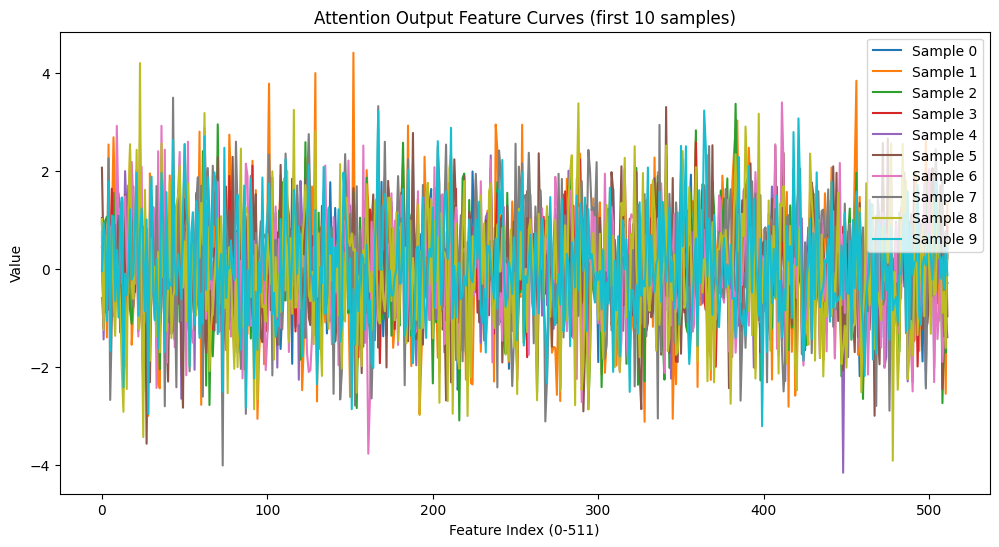

In [12]:
# Select first 10 samples
N = 10
sample_inputs = X_val[:N]

# Get the output of attention layer
attn_outputs = attention_extractor.predict(sample_inputs)
attn_outputs = np.squeeze(attn_outputs, axis=1)  # transform the shape to (N, 512)

# plot feature distribution for each sample
plt.figure(figsize=(12, 6))
for i in range(N):
    plt.plot(attn_outputs[i], label=f'Sample {i}')
plt.title('Attention Output Feature Curves (first {} samples)'.format(N))
plt.xlabel('Feature Index (0-511)')
plt.ylabel('Value')
plt.legend()
plt.show()


Generally, this plot shows the attention output feature curves for the first 10 samples.

The x-axis represents the feature index (0–511), covering all 512 attention dimensions.

The y-axis shows the feature values across those dimensions.

Each colored line corresponds to one sample (Sample 0–9).

Overall, we can see that:

The attention outputs vary across samples, indicating the model produces diverse attention patterns.

There’s no collapse to zero or constant values, which suggests the attention layer is active and contributing meaningful information.

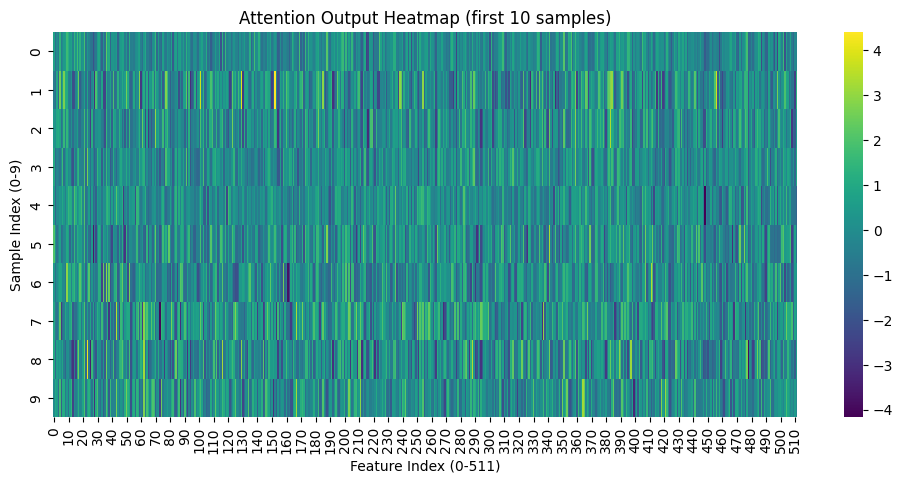

In [13]:
# heatmap：feature(horizontal) X sample (vertical)
plt.figure(figsize=(12, N // 2))
sns.heatmap(attn_outputs, cmap='viridis', cbar=True)
plt.title('Attention Output Heatmap (first {} samples)'.format(N))
plt.xlabel('Feature Index (0-511)')
plt.ylabel('Sample Index (0-{})'.format(N - 1))
plt.show()


The color scale indicates feature values, from approximately −4 (purple) to +4 (yellow).

There is clear variation across both samples and features, indicating active and differentiated attention outputs.

Some feature columns show consistently higher or lower values, while others vary more across samples.

This suggests that the attention layer is producing diverse patterns that could help distinguish samples in downstream tasks.

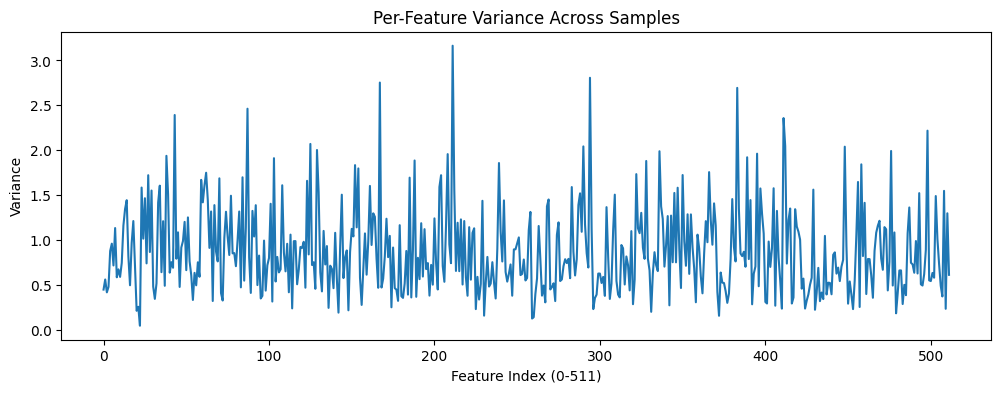

Top 10 most variable features (by index): [211 294 167 383  87  43 411 498 125 412]
Top 10 least variable features (by index): [ 22 259 260 372 230 479 142 331  20 148]


In [14]:
# calculate the variance for each feature
feature_variances = np.var(attn_outputs, axis=0)  # shape (512,)

# plot the variance
plt.figure(figsize=(12, 4))
plt.plot(feature_variances)
plt.title('Per-Feature Variance Across Samples')
plt.xlabel('Feature Index (0-511)')
plt.ylabel('Variance')
plt.show()

# get the top10 and bottom10 features based on var values.
top_n = 10
top_indices = np.argsort(-feature_variances)[:top_n]
bottom_indices = np.argsort(feature_variances)[:top_n]

print(f"Top {top_n} most variable features (by index): {top_indices}")
print(f"Top {top_n} least variable features (by index): {bottom_indices}")


Top 10 most variable features: e.g., 496, 62, 247 → these features vary the most between samples and may carry important discriminative signals.

Top 10 least variable features: e.g., 75, 450, 93 → these features show very little change across samples and may be redundant or less informative.

However, as these features are already very abstract, we can hardly explain them in a direct way, but we can know how one of the top features function in predicting the emotions.

/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


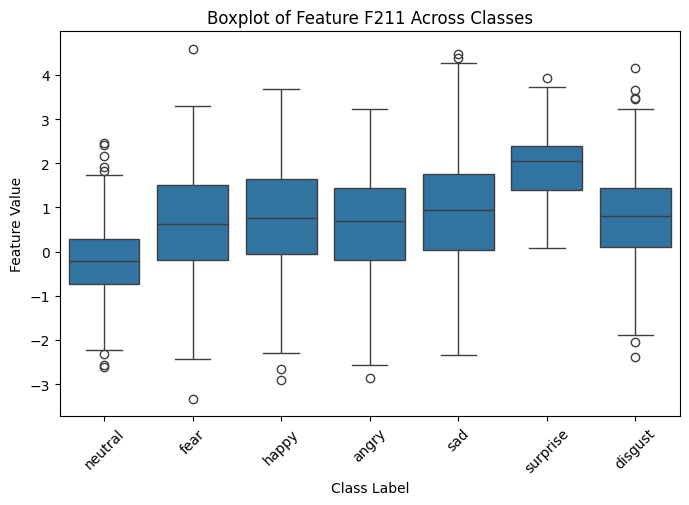

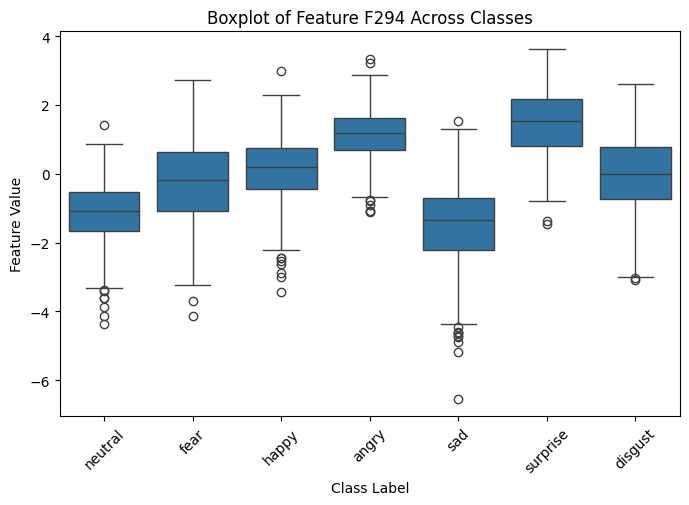

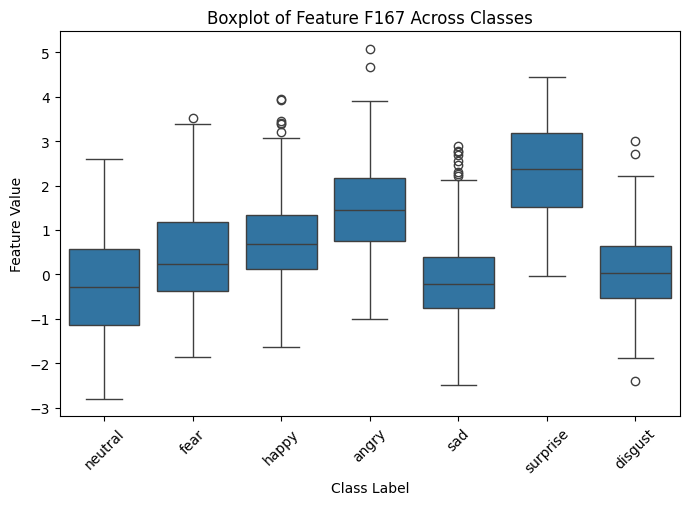

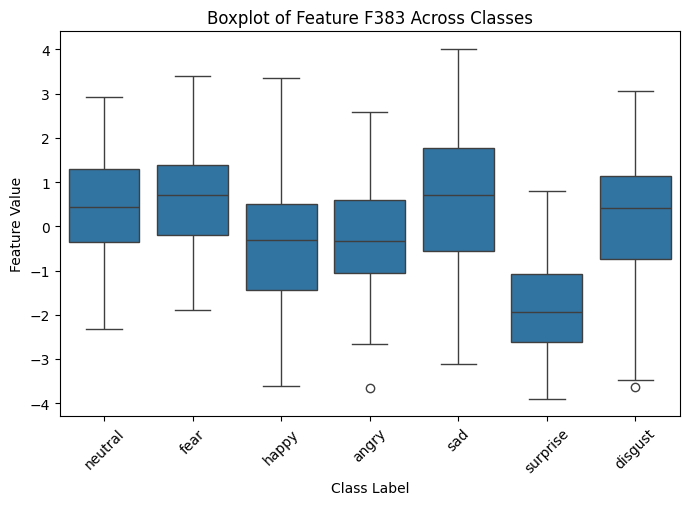

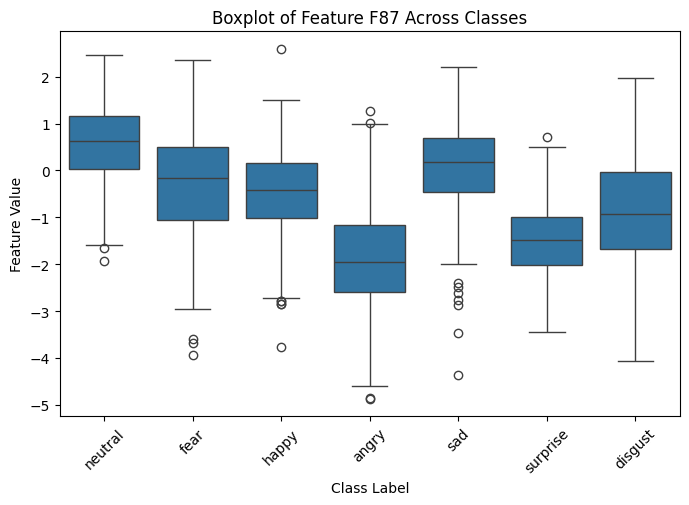

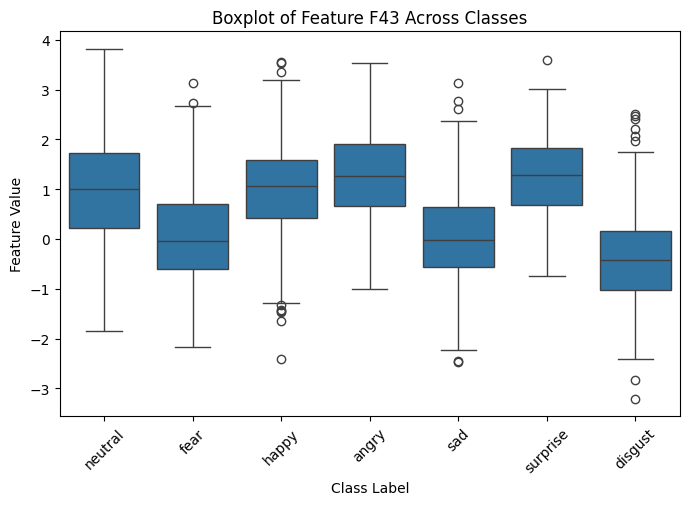

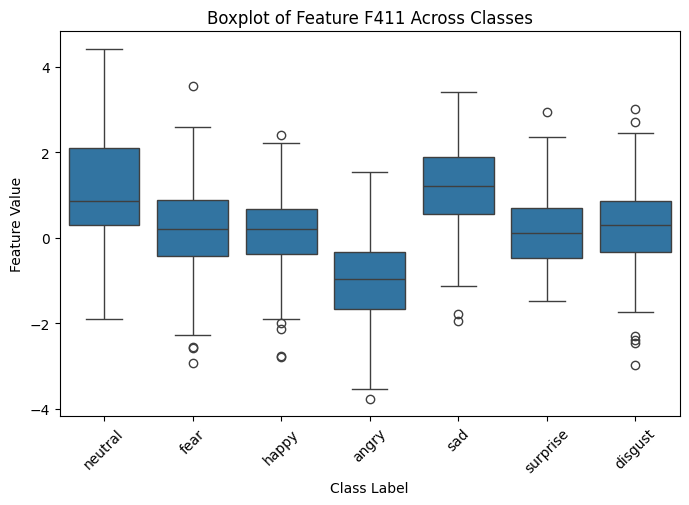

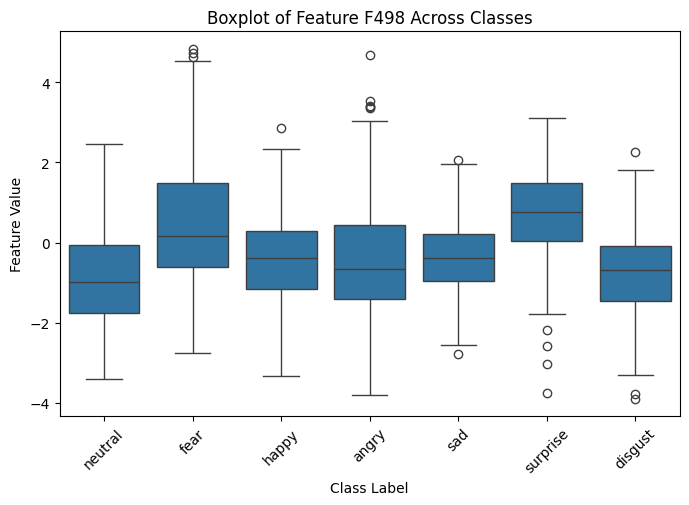

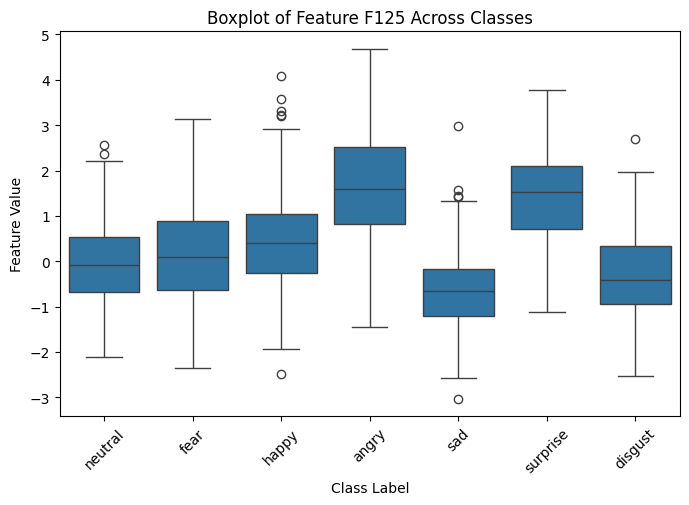

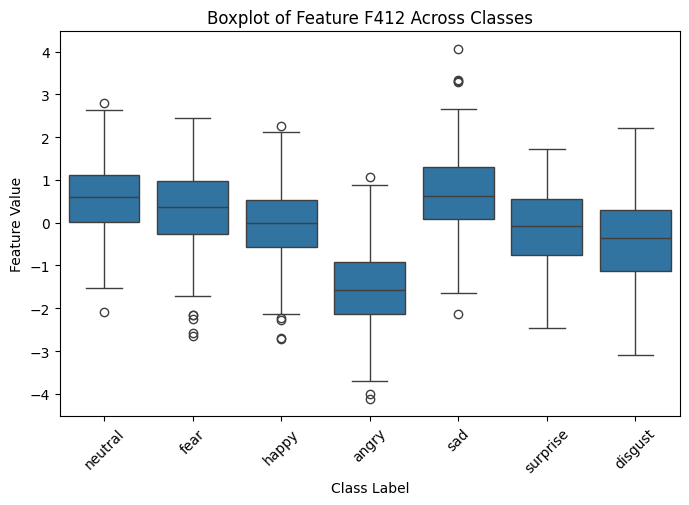

In [15]:

attn_outputs = attention_extractor.predict(X_val)
attn_outputs = np.squeeze(attn_outputs, axis=1)


y_val = np.load('./hubert_meanstd_no_aug/y_val.npy')  # (N, num_classes) one-hot
with open('./hubert_meanstd_no_aug/label_names.json', 'r') as f:
    label_names = json.load(f)

# transform one-hot back to labels
y_val_indices = np.argmax(y_val, axis=1)
y_val_labels = np.array([label_names[idx] for idx in y_val_indices])

# top10 variance features
top_attn_outputs = attn_outputs[:, top_indices]

df = pd.DataFrame(top_attn_outputs, columns=[f'F{idx}' for idx in top_indices])
df['label'] = y_val_labels

# boxplot
for col in df.columns[:-1]:
    plt.figure(figsize=(8, 5))
    sns.boxplot(x='label', y=col, data=df)
    plt.title(f'Boxplot of Feature {col} Across Classes')
    plt.xlabel('Class Label')
    plt.ylabel('Feature Value')
    plt.xticks(rotation=45)
    plt.show()
